In [35]:
%matplotlib inline

We use scikit-learn for machibne learning and pandas for analyzing the data.

In [10]:
import sklearn, pandas
import numpy as np

We load the pre-prepared training data. This file was created with `get_data.py`.

In [11]:
d = pandas.read_csv("training.csv")

In [12]:
d.head()

,Unnamed: 0,fn,cela_hist_0,cela_hist_10,cela_hist_20,cela_hist_30,cela_hist_40,cela_hist_50,cela_hist_60,bstat_64_0,...,bstat_64_3,bstat_64_4,bstat_64_5,bstat_64_6,bstat_64_7,bstat_64_8,bstat_64_9,type,rnd,id
0,0,/Users/joosep/Dropbox/diplohack_team2/photos/t...,0.210865,0.499997,0.5,0.5,0.999960,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,1
1,0,/Users/joosep/Dropbox/diplohack_team2/photos/t...,0.210660,0.499997,0.5,0.5,0.999960,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,True,1
2,0,/Users/joosep/Dropbox/diplohack_team2/photos/t...,0.210686,0.499997,0.5,0.5,0.999960,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,1
3,0,/Users/joosep/Dropbox/diplohack_team2/photos/t...,0.210790,0.499997,0.5,0.5,0.999960,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,1
4,0,/Users/joosep/Dropbox/diplohack_team2/photos/t...,0.210196,0.499997,0.5,0.5,0.999959,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,1


Now we pre-process the data, removing bad values, replacing them with 0-s.

In [13]:
vs = []
for cn in d.columns:
    if "ela" in cn or "bstat" in cn:
        vs += [cn]
for c in vs:
    d.loc[np.isinf(d[c]), c] = 0
    d.loc[np.isnan(d[c]), c] = 0

This is a list of all the input variables we use.
  * `cela_hist_*` stands for the cumulative of the Error Level Analysis histogram
  * `bstat_*` stands for the block statistics, looking for copy-move errors.

In [14]:
vs

['cela_hist_0',
 'cela_hist_10',
 'cela_hist_20',
 'cela_hist_30',
 'cela_hist_40',
 'cela_hist_50',
 'cela_hist_60',
 'bstat_64_0',
 'bstat_64_1',
 'bstat_64_2',
 'bstat_64_3',
 'bstat_64_4',
 'bstat_64_5',
 'bstat_64_6',
 'bstat_64_7',
 'bstat_64_8',
 'bstat_64_9']

Now we split the data into independent testing an training sets based on a random value that was calculated when the data was generated.

In [15]:
d_A = d[d["rnd"] == 1]
d_B = d[d["rnd"] == 0]

In [16]:
len(d_A), len(d_B)

(1268, 3815)

This is where we construct our training algorithm. We train two independent Boosted Decision Tree ensembles on both the training and testing data in order to do cross-validation.
Here we use simple choices for the parameters of the model, using shallow trees and a moderate number of them.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

#BDT1 is trained on data A
bdt1 = GradientBoostingClassifier(n_estimators=300, max_depth=2, subsample=0.5)
bdt1.fit(d_A[vs], d_A["id"])

#BDT1 is trained on data B
bdt2 = GradientBoostingClassifier(n_estimators=300, max_depth=2, subsample=0.5)
bdt2.fit(d_B[vs], d_B["id"])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

Now we calculate the accuracy factors (0 - none are correctly classified, 1 - all were correctly classified) of both BDT-s based on the datasets. BDT1 for data A should have a high accuracy by construction, whereas BDT1 never saw data B, hence the accuracy is as it would be in real data.

In [56]:
for n1, method in [
    ("BDT1", bdt1),
    ("BDT2", bdt2)
    ]:
    for n2, data in [
        ("A", d_A),
        ("B", d_B)
    ]:
        accuracy = sklearn.metrics.accuracy_score(data["id"], method.predict(data[vs]))
        print n1, n2, accuracy

BDT1 A 0.91167192429
BDT1 B 0.81625163827
BDT2 A 0.831230283912
BDT2 B 0.873656618611


Now we see that BDT2 is about 83% accurate on data it never saw, whereas BDT1 is about 82% accurate. As these numbers are almost the same, we believe that the machine leearning technique did a good job.

In [19]:
from IPython.display import Image

In [20]:
import sys
import get_data

Now lets see how the algorithm works on just two example images.

In [83]:
i1 = "/Users/joosep/Documents/GetThePicture/study_case/ledemissiles1.jpg"
i2 = "/Users/joosep/Documents/GetThePicture/study_case/real/ledemissiles2.jpg"

Now lets look at a candidate image.

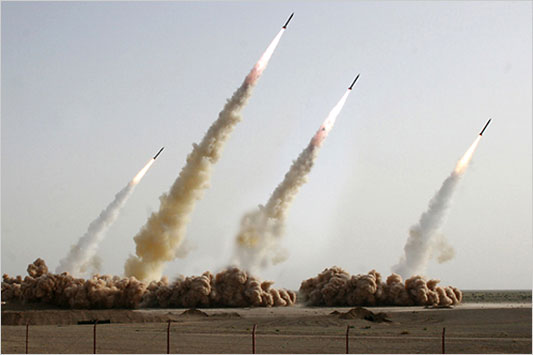

In [84]:
Image(filename=i1)

If we look at the compression artifacts, we see something rather unnatural: it seems like the images of the children have been copied to the background.

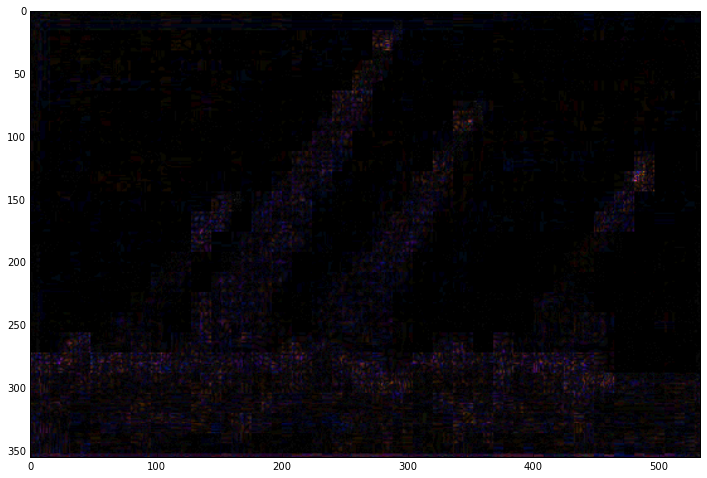

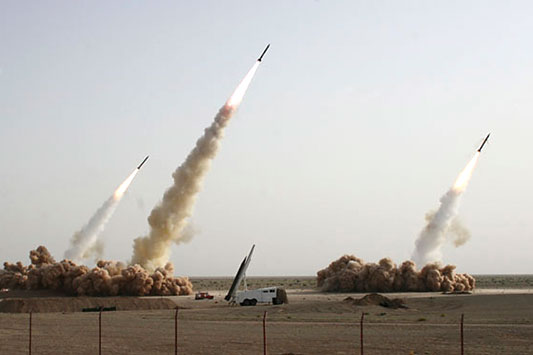

In [86]:
Image(filename=i2)

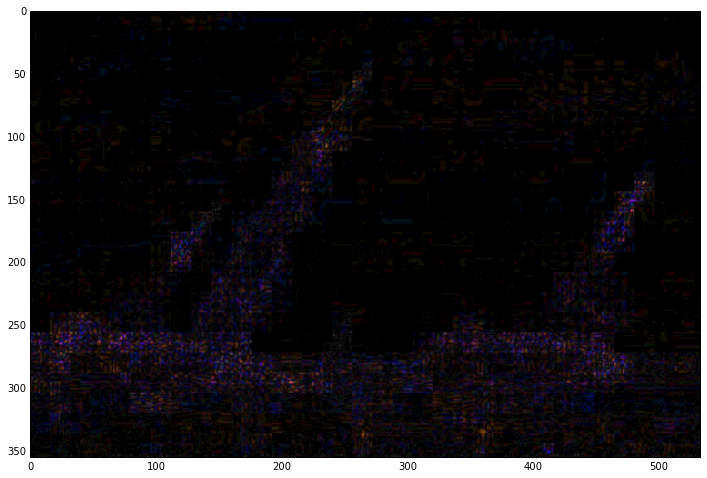

In [87]:
ela2 = get_data.get_ela(i2)
plt.figure(figsize=(12,12))
plt.imshow(ela2)

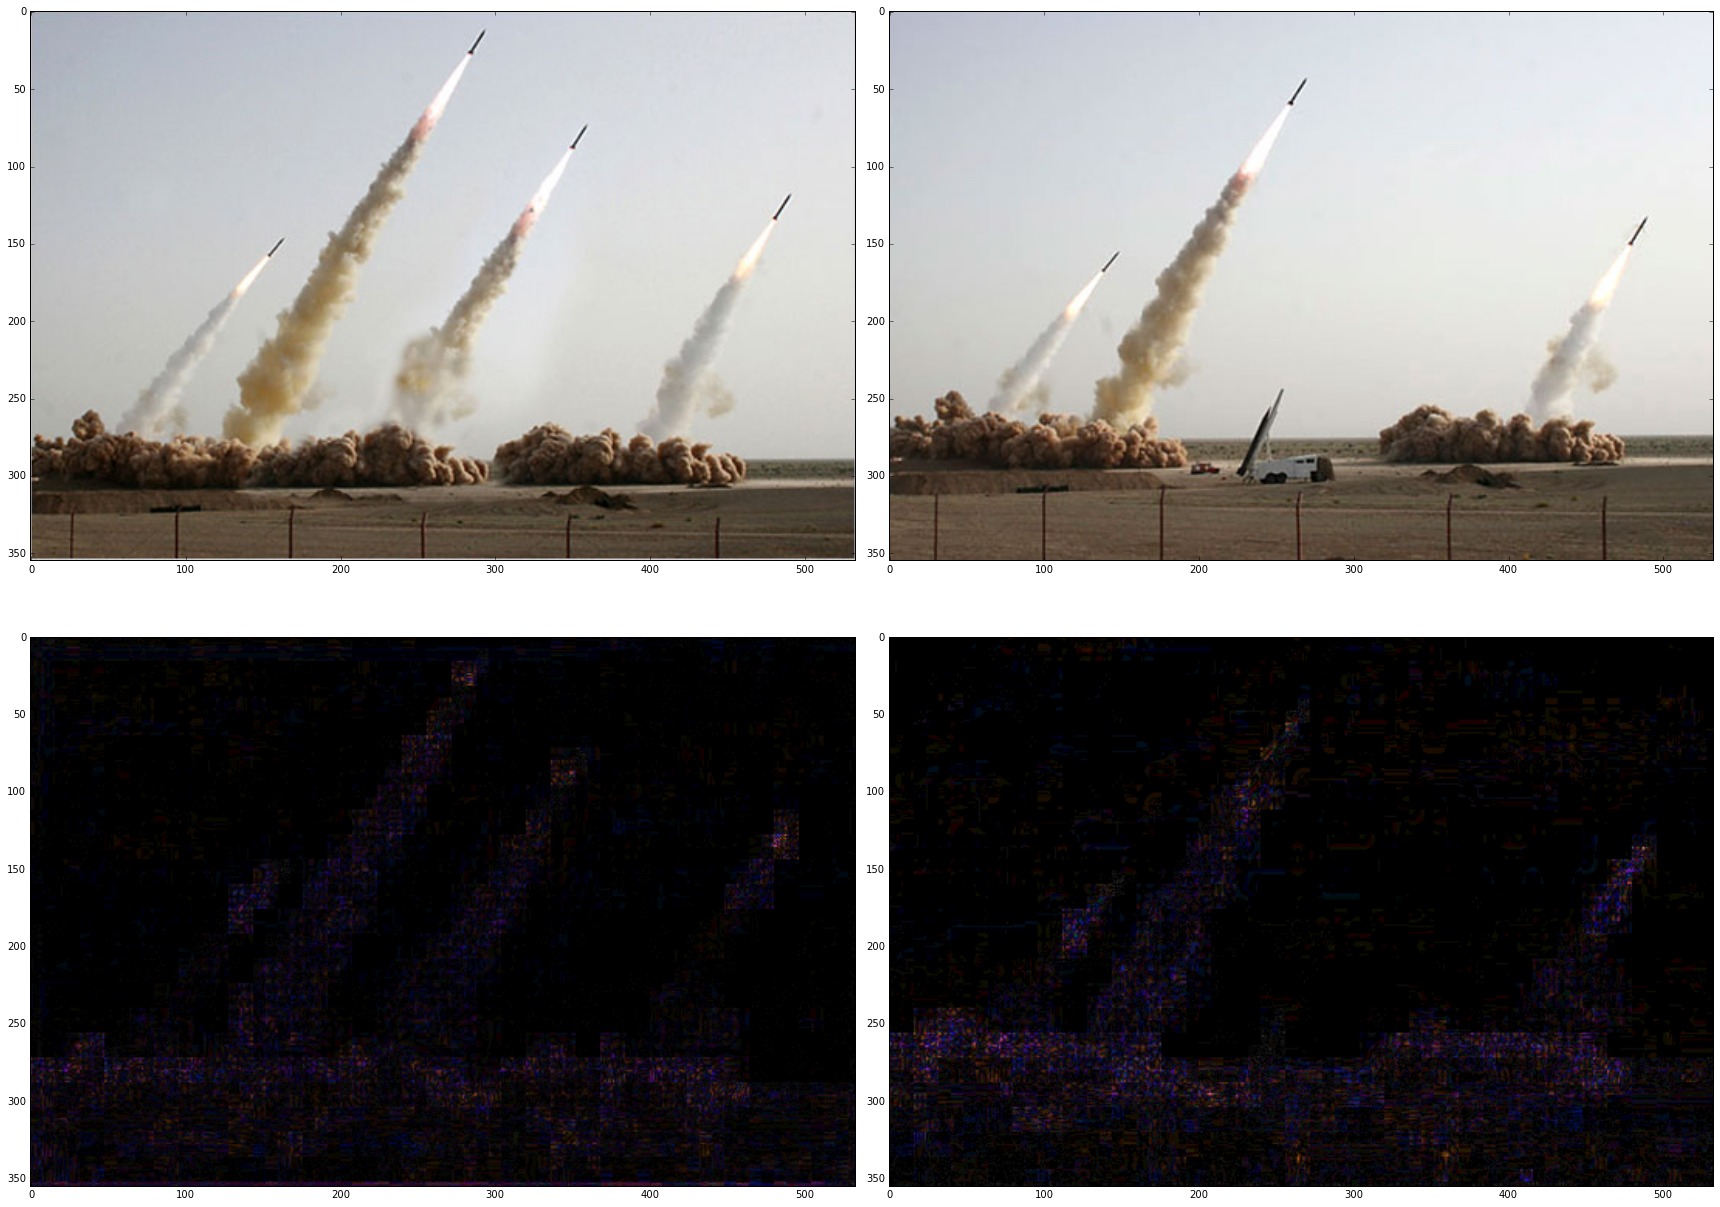

In [104]:
plt.figure(figsize=(24,18))
plt.subplot(2,2,1)
plt.imshow(mpimg.imread(i1))
plt.subplot(2,2,2)
plt.imshow(mpimg.imread(i2))

plt.subplot(2,2,3)
ela1 = get_data.get_ela(i1)
plt.imshow(ela1)
plt.subplot(2,2,4)
ela2 = get_data.get_ela(i2)
plt.imshow(ela2)

plt.tight_layout()

We see that the spectrum for the unmanipulated

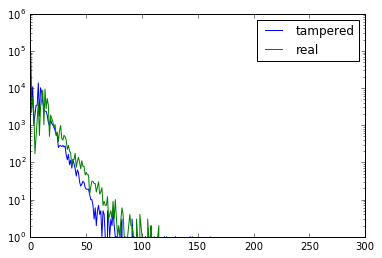

In [105]:
plt.plot(ela1.convert("L").histogram(), label="tampered")
plt.plot(ela2.convert("L").histogram(), label="real")
plt.yscale("log")
plt.legend()

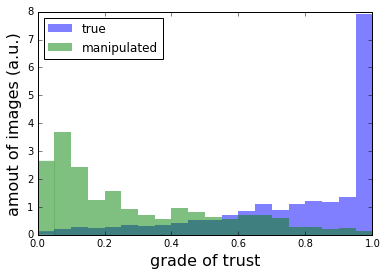

In [106]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(bdt1.predict_proba(d_B[d_B["id"]==0][vs])[:, 0], bins=np.linspace(0,1,21), alpha=0.5, label="true", lw=0, normed=True);
plt.hist(bdt1.predict_proba(d_B[d_B["id"]==1][vs])[:, 0], bins=np.linspace(0,1,21), alpha=0.5, label="manipulated", lw=0, normed=True);
plt.legend(loc="best")
plt.xlabel("grade of trust", fontsize=16)
plt.ylabel("amout of images (a.u.)", fontsize=16)

In [ ]:
import glob
real = glob.glob("/Users/joosep/Dropbox/diplohack_team2/photos/realistic/*.jpg")

In [ ]:
import PIL

In [ ]:
import matplotlib.image as mpimg
for r in real:
    plt.figure(figsize=(12,12))
    i = mpimg.imread(r)
    plt.imshow(i)
    ds = get_data.get_image_data(r)[vs]
    for v in vs:
        ds.loc[np.isnan(ds[v]), v] = 0
    score = bdt2.predict_proba(
        ds
    )
    plt.title("Evidence of tampering: %.2f" % score[:,0], fontsize=24)

In [51]:
import pickle

In [52]:
s1 = pickle.dumps(bdt1)

In [53]:
s2 = pickle.dumps(bdt2)

In [54]:
of1 = open("/Users/joosep/Dropbox/diplohack_team2/bdt1.pkl", "w")
of1.write(s1)
of1.close()

In [55]:
of2 = open("/Users/joosep/Dropbox/diplohack_team2/bdt2.pkl", "w")
of2.write(s2)
of2.close()

In [31]:
import cv2

In [32]:
i = cv2.imread(real2[0], cv2.CV_LOAD_IMAGE_GRAYSCALE)

In [33]:
surf = cv2.SURF(10000)

In [34]:
kp, des = surf.detectAndCompute(i,None)

In [35]:
img2 = cv2.drawKeypoints(i, kp, None, (255, 0, 0),4)

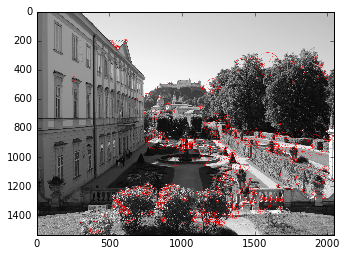

In [36]:
plt.imshow(img2)

In [41]:
get_data.get_image_data(real[0])

/Users/joosep/Dropbox/diplohack_team2/photos/Robert/00467683-6188a172539515aa3f999d621cbe975b.jpg


,fn,cela_hist_0,cela_hist_10,cela_hist_20,cela_hist_30,cela_hist_40,cela_hist_50,cela_hist_60,bstat_64_0,bstat_64_1,bstat_64_2,bstat_64_3,bstat_64_4,bstat_64_5,bstat_64_6,bstat_64_7,bstat_64_8,bstat_64_9,type,rnd
0,/Users/joosep/Dropbox/diplohack_team2/photos/R...,0.313923,0.494346,0.499945,0.499998,0.992564,0.999816,0.999998,0.450593,1.494071,0.055336,0,0,0,0,0,0,0,1,False
